In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from data import *
from amorgibbs import *
from plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 50
T_max = 60
K = 4
D = 2
dt = 5
Boundary = 30
noise_ratio = 10.0

## Model Parameters
num_particles_rws = 10
mcmc_steps = 5
num_particles_smc = 30
NUM_HIDDEN = 32
NUM_LATENTS = K*K
NUM_OBS = 2 * K

NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "weights/enc-%drws-%dmcmc-%dsmc-enc-%s" % (num_particles_rws, mcmc_steps, num_particles_smc, datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

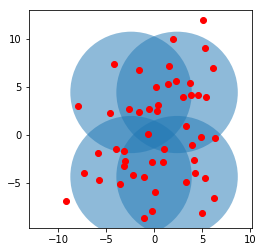

In [3]:
T = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio       
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle

STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)

plot_clusters(Y.data.numpy(), mu_ks.data.numpy(), cov_ks.data.numpy(), K)

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, prior):
        A_sample = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        variational = F.softmax(self.latent_dir(hidden), -1).sum(0).view(K, K) + prior
        for k in range(K):
            A_sample[k] = Dirichlet(variational[k]).sample()
        return variational, A_sample

In [5]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [6]:
KLs = []
EUBOs = []
log_qs = []
ESSs = []## Dataset parameters
ELBOs = []

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    STATE, mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq(T, K, dt, Boundary, init_v, noise_cov)
    
    eubo, kl, ess, variational, elbo  = rws_decompose1_rao(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles_rws, num_particles_smc, mcmc_steps)
    eubo.backward()
    optimizer.step()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ELBOs.append(elbo.item())
    ESSs.append(ess)
    optimizer.zero_grad()
    time_end = time.time()
    print('epoch : %d, EUBO : %f, ELBO : %f, KL : %f (%ds)' % (epoch, eubo, elbo, kl, time_end - time_start))
    
# if RESTORE:
#     enc.load_state_dict(torch.load(PATH_ENC))
# else:
#     torch.save(enc.state_dict(), PATH_ENC)
# save_params(KLs, EUBOs, ELBOs, ESSs, PATH_ENC)

epoch : 0, EUBO : -255.080902, ELBO : -345.431335, KL : 14.565684 (4s)
epoch : 1, EUBO : -230.055786, ELBO : -385.802307, KL : 20.921412 (4s)
epoch : 2, EUBO : -247.702118, ELBO : -354.115723, KL : 15.615062 (4s)
epoch : 3, EUBO : -251.420181, ELBO : -373.970062, KL : 21.296665 (4s)
epoch : 4, EUBO : -237.411407, ELBO : -340.958069, KL : 15.070635 (4s)
epoch : 5, EUBO : -246.720810, ELBO : -330.143616, KL : 11.282089 (4s)
epoch : 6, EUBO : -267.186737, ELBO : -338.456390, KL : 16.235035 (4s)
epoch : 7, EUBO : -231.189240, ELBO : -337.675110, KL : 16.618158 (4s)
epoch : 8, EUBO : -261.403137, ELBO : -361.809174, KL : 16.119673 (4s)
epoch : 9, EUBO : -204.853607, ELBO : -332.425201, KL : 17.373375 (4s)
epoch : 10, EUBO : -210.541260, ELBO : -337.751312, KL : 15.254910 (4s)
epoch : 11, EUBO : -214.668167, ELBO : -322.052887, KL : 15.092367 (4s)
epoch : 12, EUBO : -239.439331, ELBO : -348.502380, KL : 17.796154 (4s)
epoch : 13, EUBO : -247.711151, ELBO : -361.050171, KL : 15.584471 (4s)
ep

In [7]:
save_params(KLs, EUBOs, ELBOs, ESSs, PATH_ENC)

ValueError: only one element tensors can be converted to Python scalars

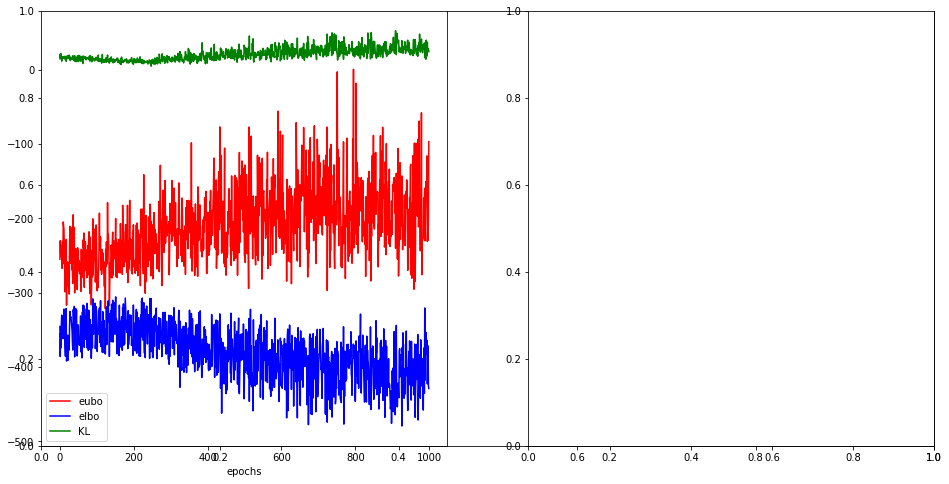

In [8]:
plot_results(EUBOs, ELBOs, KLs, ESSs, PATH_ENC)

In [ ]:
# plot_dirs(variational, alpha_trans_0, Zs_true, T, K, vmax=15)